## Ideal Backstepping Controller
---

### 1. Position subsystem (x, y)

**Define errors:**

$$
\begin{align*}
z_1 &= x_d - x \\
z_2 &= v_1 - \dot{x} \\
z_3 &= y_d - y \\
z_4 &= v_3 - \dot{y}
\end{align*}
$$

**Virtual controls:**

$$
\begin{align*}
v_1 &= \dot{x}_d + k_1 z_1 \\
v_3 &= \dot{y}_d + k_3 z_3
\end{align*}
$$

**Actual controls:**

$$
\begin{align*}
U_x &= \frac{m}{U_1} \left( \ddot{x}_d + k_1 \dot{z}_1 - k_2 z_2 \right) \\
U_y &= \frac{m}{U_1} \left( \ddot{y}_d + k_3 \dot{z}_3 - k_4 z_4 \right)
\end{align*}
$$

---

### 2. Desired roll and pitch angles

From $ U_x $, $ U_y $, and $ \psi_d $:

$$
\begin{align*}
\phi_d &= \arcsin(U_x \sin(\psi_d) - U_y \cos(\psi_d)) \\
\theta_d &= \arcsin\left( \frac{U_x \cos(\psi_d) + U_y \sin(\psi_d)}{\cos(\phi_d)} \right)
\end{align*}
$$

---

### 3. Altitude subsystem (z)

**Define errors:**

$$
\begin{align*}
z_5 &= z_d - z \\
z_6 &= v_5 - \dot{z}
\end{align*}
$$

**Virtual control:**

$$
v_5 = \dot{z}_d + k_5 z_5
$$

**Actual control:**

$$
U_1 = \frac{m}{\cos(\phi) \cos(\theta)} \left( g + \ddot{z}_d + k_5 \dot{z}_5 - k_6 z_6 \right)
$$

---

### 4. Attitude subsystem (φ, θ, ψ)

**Roll (φ):**

$$
\begin{align*}
z_7 &= \phi_d - \phi \\
z_8 &= v_7 - \dot{\phi} \\
v_7 &= \dot{\phi}_d + k_7 z_7 \\
U_2 &= \frac{J_x}{l} \left( f_\phi + \ddot{\phi}_d + k_7 \dot{z}_7 - k_8 z_8 \right)
\end{align*}
$$

**Pitch (θ):**

$$
\begin{align*}
z_9 &= \theta_d - \theta \\
z_{10} &= v_9 - \dot{\theta} \\
v_9 &= \dot{\theta}_d + k_9 z_9 \\
U_3 &= \frac{J_y}{l} \left( f_\theta + \ddot{\theta}_d + k_9 \dot{z}_9 - k_{10} z_{10} \right)
\end{align*}
$$

**Yaw (ψ):**

$$
\begin{align*}
z_{11} &= \psi_d - \psi \\
z_{12} &= v_{11} - \dot{\psi} \\
v_{11} &= \dot{\psi}_d + k_{11} z_{11} \\
U_4 &= J_z \left( f_\psi + \ddot{\psi}_d + k_{11} \dot{z}_{11} - k_{12} z_{12} \right)
\end{align*}
$$

---

### 5. Yaw Reference Options

**Point along velocity**

$$
\psi_d(t) = \arctan(\dot{y}_d(t),\, \dot{x}_d(t))
$$




100%|██████████| 4000/4000 [00:00<00:00, 4133.95it/s]


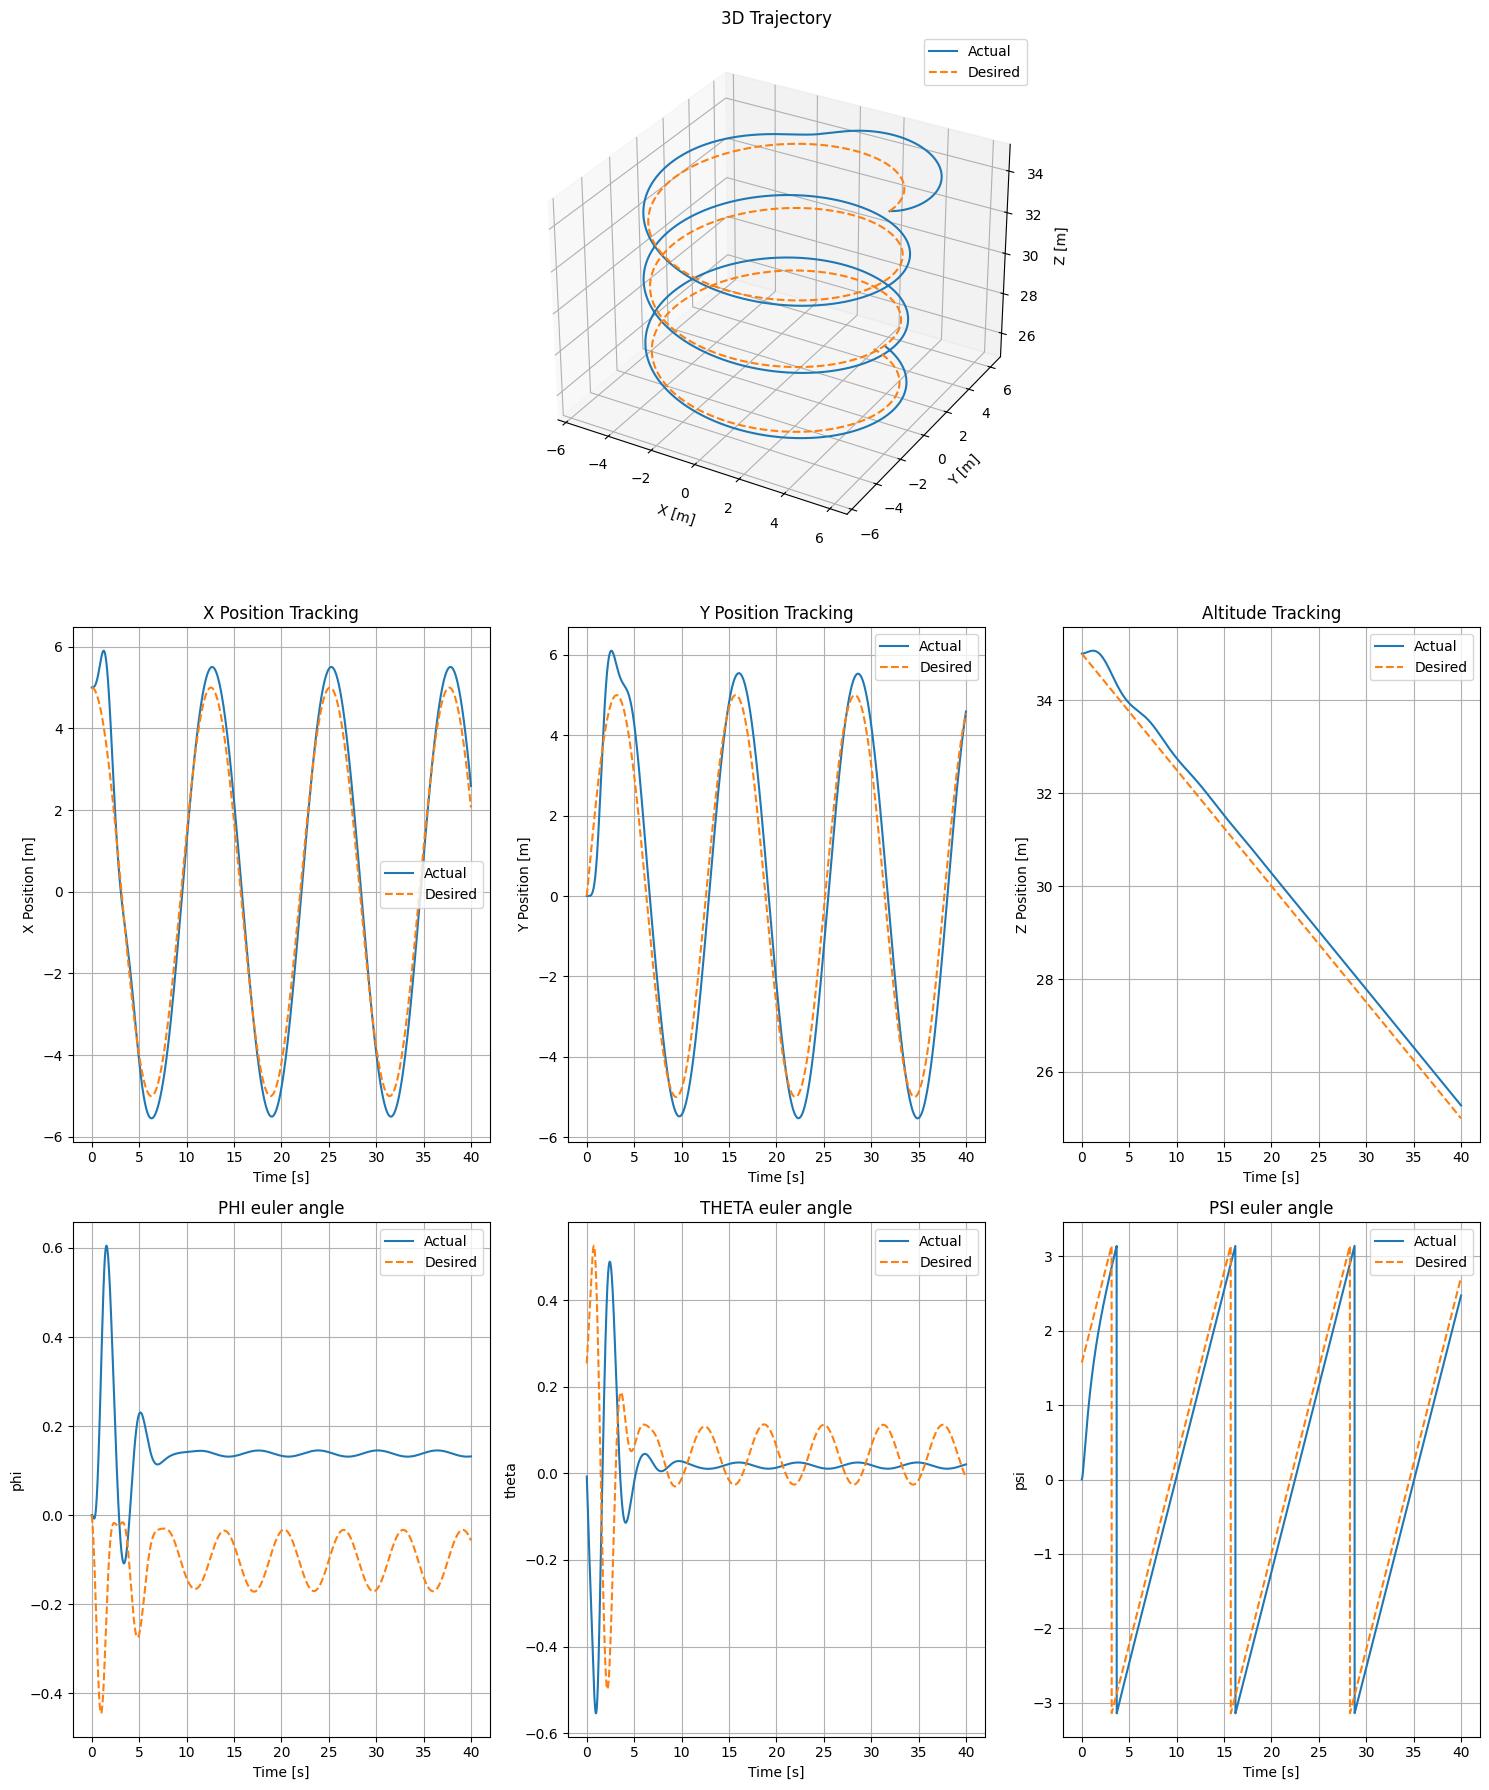

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from abc import ABC, abstractmethod
from tqdm import tqdm
import pandas as pd


def wrap_angle(angle):
    """
    Wraps the given angle to the range [-pi, +pi].

    :param angle: The angle (in rad) to wrap (can be unbounded).
    :return: The wrapped angle (guaranteed to in [-pi, +pi]).
    """

    pi2 = 2 * np.pi

    while angle < -np.pi:
        angle += pi2

    while angle >= np.pi:
        angle -= pi2
        
    return angle


# ======================================
#              Plant Class
# ======================================
class Plant(ABC):
    def __init__(self, initial_state, dt):
        self.state = np.array(initial_state, dtype=np.float64)
        self.dt = dt

    @abstractmethod
    def _get_derivatives(self, action):
        pass

    def step(self, action):
        derivatives = self._get_derivatives(action)
        self.state += derivatives * self.dt
        for i in range(3):
            self.state[i*2] = wrap_angle(self.state[i*2])
        return self.state

# --------------------------------------
#             UAV Implementation
# --------------------------------------
class UAV(Plant):
    def __init__(self, initial_state, dt, params):
        super().__init__(initial_state, dt)
        self.params = params
        self.m = params['m']
        self.Ix = params['Ix']
        self.Iy = params['Iy']
        self.Iz = params['Iz']
        self.g = params['g']

    def _get_derivatives(self, action):
        U1, U2, U3, U4 = action
        phi, p, theta, q, psi, r, z, vz, y, vy, x, vx = self.state
        
        # Translation dynamics
        ax = -(U1/self.m) * (np.sin(phi)*np.sin(psi) + np.cos(phi)*np.sin(theta)*np.cos(psi))
        ay = -(U1/self.m) * (np.cos(phi)*np.sin(theta)*np.sin(psi) - np.sin(phi)*np.cos(psi))
        az = self.g - (U1/self.m)*np.cos(phi)*np.cos(theta)

        vx = vx + ax * self.dt
        vy = vy + ay * self.dt
        vz = vz + az * self.dt
        
        # Rotation dynamics
        p_dot = ((self.Iy - self.Iz)/self.Ix)*q*r + U2/self.Ix
        q_dot = ((self.Iz - self.Ix)/self.Iy)*p*r + U3/self.Iy
        r_dot = ((self.Ix - self.Iy)/self.Iz)*p*q + U4/self.Iz
        
        # Kinematics
        phi_dot = p + q*np.sin(phi)*np.tan(theta) + r*np.cos(phi)*np.tan(theta)
        theta_dot = q*np.cos(phi) - r*np.sin(phi)
        psi_dot = (q*np.sin(phi) + r*np.cos(phi)) / np.cos(theta)

        phi_dot = p + p_dot * self.dt
        theta_dot = q + q_dot * self.dt
        psi_dot = r + r_dot * self.dt
        
        return np.array([
            phi_dot, p_dot, theta_dot, q_dot, psi_dot, r_dot,
            vz, az, vy, ay, vx, ax
        ])

# ======================================
#            Controller Class
# ======================================


import numpy as np

import numpy as np

class DroneController:
    def __init__(self):
        # Existing parameters
        self.m = 0.4794  # mass
        self.g = 9.81
        self.Ix = 0.0086
        self.Iy = 0.0086
        self.Iz = 0.0172
        # self.Jr = 3.740e-5 # Rotor inertia - No longer used in the controller if gyroscopic terms are fully removed

        self.center = np.array([0,0])
        self.R = 5
        self.omega = 0.5
        self.h_rate = 0.25

        # Backstepping Gains
        self.K_phi1 = 1.0
        self.K_phi2 = 1.0
        self.K_theta1 = 1.0
        self.K_theta2 = 1.0
        self.K_psi1 = 1.0
        self.K_psi2 = 1.0
        self.K_z1 = 1.0
        self.K_z2 = 1.5
        self.K_x1 = 1.0
        self.K_x2 = 2.5
        self.K_y1 = 1.5
        self.K_y2 = 1.0

        self.prev_phi_d = 0.0
        self.prev_theta_d = 0.0
        
        # Define typical limits
        self.max_total_thrust = self.m * self.g * 2.5
        self.max_torque_roll_pitch = 0.7
        self.max_torque_yaw = 1


    def get_action(self, state, t, dt):
        # Desired trajectory calculations
        x_d = self.center[0] + self.R * np.cos(self.omega * t)
        y_d = self.center[1] + self.R * np.sin(self.omega * t)
        
        start_z = 35.0
        z_d = 35.0 - self.h_rate * t
        vz_d = - self.h_rate
        
        vx_d = -self.R * self.omega * np.sin(self.omega * t)
        vy_d = self.R * self.omega * np.cos(self.omega * t)

        ax_d = -self.R * self.omega**2 * np.cos(self.omega * t)  
        ay_d = -self.R * self.omega**2 * np.sin(self.omega * t)  
        
        # Desired yaw and its derivative
        if np.linalg.norm([vx_d, vy_d]) > 1e-6:
             psi_d = np.arctan2(vy_d, vx_d)
        else:
            psi_d = state[4] 
        # psi_d = np.arctan2(-(y_d - self.center[1]),
        #                       -(x_d - self.center[0]))

        psi_dot_d = (vx_d * ay_d - vy_d * ax_d) / (vx_d**2 + vy_d**2 + 1e-9)
        # psi_dot_d = (x_d**2*(vy_d*x_d-vx_d*y_d))/((x_d**2+y_d**2)*y_d**2+1e-9)


        # Current state
        phi, p, theta, q, psi, r, z, vz, y, vy, x, vx = state
        
        # ===== Altitude Control (U1) =====
        e_z = z_d - z
        e_vz = vz_d - vz 
        U1 = (self.m / (np.cos(phi)*np.cos(theta) + 1e-9)) * \
             (self.g + self.K_z1*e_vz - self.K_z2*(vz_d+self.K_z1*e_z-vz))
        U1 = np.max([0, U1]) 

        # ===== Horizontal Position Control (Ux, Uy) =====
        e_x = x_d - x
        e_vx = vx_d - vx 
        Ux_desired_acc_term = (e_x - self.K_x1*e_vx - self.K_x2*(vx_d+self.K_x1*e_x-vx))
        Ux = (self.m/(U1 + 1e-9)) * Ux_desired_acc_term

        e_y = y_d - y
        e_vy = vy_d - vy 
        Uy_desired_acc_term = (e_y - self.K_y1*e_vy - self.K_y2*(vy_d+self.K_y1*e_y-vy))
        Uy = (self.m/(U1 + 1e-9)) * Uy_desired_acc_term
        
        # ===== Attitude Control Setpoints (phi_d, theta_d) =====
        Ux_clamped = np.clip(Ux, -2, 2) 
        Uy_clamped = np.clip(Uy, -2, 2)

        val_phi_arcsin = Ux_clamped*np.sin(psi_d) - Uy_clamped*np.cos(psi_d)
        phi_d = np.arcsin(np.clip(val_phi_arcsin, -1.0, 1.0))
        
        cos_phi_d = np.cos(phi_d)
        if np.abs(cos_phi_d) < 1e-4:
            cos_phi_d = np.sign(cos_phi_d) * 1e-4 if cos_phi_d != 0 else 1e-4
            
        val_theta_arcsin = (Ux_clamped*np.cos(psi_d) + Uy_clamped*np.sin(psi_d)) / cos_phi_d
        theta_d = np.arcsin(np.clip(val_theta_arcsin, -1.0, 1.0))

        # ===== Desired Angular Rates (phi_dot_d, theta_dot_d) by Numerical Differentiation =====
        if dt > 1e-9:
            phi_dot_d = (phi_d - self.prev_phi_d) / dt
            theta_dot_d = (theta_d - self.prev_theta_d) / dt
        else:
            phi_dot_d = 0.0
            theta_dot_d = 0.0
        self.prev_phi_d = phi_d
        self.prev_theta_d = theta_d
        
        # Parameters from article
        b1 = 0.2 / self.Ix 
        b2 = 0.2 / self.Iy 
        b3 = 0.2 / self.Iz 

        a1 = (self.Iy - self.Iz) / self.Ix
        # a2_article = self.Jr / self.Ix # Jr and a2_article no longer used for U2
        
        a4_article = (self.Iz - self.Ix) / self.Iy 
        # a5_article = self.Jr / self.Iy # Jr and a5_article no longer used for U3

        a7 = (self.Ix - self.Iy) / self.Iz

        # Omega_r (residual rotor speed) is no longer used.

        # ===== Roll Control (U2) - Gyroscopic term fully removed =====
        epsilon_phi = phi_d - phi
        p_d = phi_dot_d + self.K_phi1 * epsilon_phi
        epsilon_p = p_d - p
        
        U2 = (1.0/b1) * (epsilon_phi              
                         - self.K_phi1 *  p      
                         - a1 * q * r            
                         + self.K_phi2 * epsilon_p 
                        )

        # ===== Pitch Control (U3) - Gyroscopic term fully removed =====
        epsilon_theta = theta_d - theta
        q_d = theta_dot_d + self.K_theta1 * epsilon_theta
        epsilon_q = q_d - q

        U3 = (1.0/b2) * (epsilon_theta            
                         - self.K_theta1 * q      
                         - a4_article * p * r       # Coupling term
                         + self.K_theta2 * epsilon_q
                        )
        
        # ===== Yaw Control (U4) - Backstepping structure =====
        epsilon_psi = psi_d - psi
        epsilon_psi = (epsilon_psi + np.pi) % (2 * np.pi) - np.pi

        r_d = psi_dot_d + self.K_psi1 * epsilon_psi
        epsilon_r = r_d - r
        
        U4 = (1.0/b3) * (epsilon_psi
                         - self.K_psi1 * r         
                         - a7 * p * q             # Coupling term
                         + self.K_psi2 * epsilon_r
                        )
        
        # Clip actions to actuator limits
        U1_clipped = np.clip(U1, 0, self.max_total_thrust)
        U2_clipped = np.clip(U2, -self.max_torque_roll_pitch, self.max_torque_roll_pitch)
        U3_clipped = np.clip(U3, -self.max_torque_roll_pitch, self.max_torque_roll_pitch)
        U4_clipped = np.clip(U4, -self.max_torque_yaw, self.max_torque_yaw)

        return np.array([U1_clipped, U2_clipped, U3_clipped, U4_clipped])
    

# ======================================
#            Simulation Class
# ======================================
class Simulation:
    def __init__(self, plant, controller, total_time):
        self.plant = plant
        self.controller = controller
        self.total_time = total_time
        self.data = []
        
    def run(self):
        steps = int(self.total_time / self.plant.dt)
        for _ in tqdm(range(steps)):
            t = _ * self.plant.dt
            
            # Trajectory calculations
            x_d = self.controller.center[0] + self.controller.R * np.cos(self.controller.omega * t)
            y_d = self.controller.center[1] + self.controller.R * np.sin(self.controller.omega * t)
            z_d = 35.0 - self.controller.h_rate * t
            
            # Velocity calculations
            vx_d = -self.controller.R * self.controller.omega * np.sin(self.controller.omega * t)
            vy_d = self.controller.R * self.controller.omega * np.cos(self.controller.omega * t)
            vz_d = -self.controller.h_rate
            
            # Yaw calculations
            # psi_d = np.arctan2(-(y_d - self.controller.center[1]),
            #                   -(x_d - self.controller.center[0]))
            
            if np.linalg.norm([vx_d, vy_d]) > 1e-6:
                psi_d = np.arctan2(vy_d, vx_d)
            else:
                psi_d = state[4] 

            ax_d = -self.controller.R * self.controller.omega**2 * np.cos(self.controller.omega * t)  
            ay_d = -self.controller.R * self.controller.omega**2 * np.sin(self.controller.omega * t)  
            # psi_dot_d = (x_d**2*(vy_d*x_d-vx_d*y_d))/((x_d**2+y_d**2)*y_d**2)
            psi_dot_d = (vx_d * ay_d - vy_d * ax_d) / (vx_d**2 + vy_d**2 + 1e-9)
            
            # Simulation step
            action = self.controller.get_action(self.plant.state, t, self.plant.dt)
            state = self.plant.step(action)
            
            # Intermediate calculations
            U1 = action[0]
            if U1 == 0:
                U1 = 1e-6  # Avoid division by zero
                
            Ux_val = (self.controller.m/U1) * (
                self.controller.K_x1*(x_d - state[10]) + 
                self.controller.K_x2*(vx_d - state[11])
            )
            Uy_val = (self.controller.m/U1) * (
                self.controller.K_y1*(y_d - state[8]) + 
                self.controller.K_y2*(vy_d - state[9])
            )
            
            phi_d_val = np.arcsin(Ux_val * np.sin(psi_d) - Uy_val * np.cos(psi_d))
            theta_d_val = np.arcsin(
                (Ux_val * np.cos(psi_d) + Uy_val * np.sin(psi_d)) / 
                np.cos(phi_d_val)
            )

            # Store data
            self.data.append({
                'time': t,
                # Actual states
                'x': state[10], 'vx': state[11],
                'y': state[8], 'vy': state[9],
                'z': state[6], 'vz': state[7],
                'phi': state[0], 'p': state[1],
                'theta': state[2], 'q': state[3],
                'psi': state[4], 'r': state[5],
                # Controls
                'U1': U1, 'U2': action[1], 'U3': action[2], 'U4': action[3],
                # Desired trajectory
                'x_d': x_d, 'vx_d': vx_d,
                'y_d': y_d, 'vy_d': vy_d,
                'z_d': z_d, 'vz_d': vz_d,
                'psi_d': psi_d, 'psi_dot_d': psi_dot_d,
                # Intermediate values
                'Ux': Ux_val, 'Uy': Uy_val,
                'phi_d': phi_d_val, 'theta_d': theta_d_val
            })
    
    def save_to_csv(self, filename):
        pd.DataFrame(self.data).to_csv(filename, index=False, float_format='%.4f')

    def plot_3d_trajectory(self):
        df = pd.DataFrame(self.data)
        
        # Create figure with subplots
        fig = plt.figure(figsize=(15, 18))
        
        # 3D trajectory plot
        ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3, projection='3d')
        ax1.plot(df['x'], df['y'], df['z'], label='Actual')
        ax1.plot(df['x_d'], df['y_d'], df['z_d'], '--', label='Desired')
        ax1.set_xlabel('X [m]')
        ax1.set_ylabel('Y [m]')
        ax1.set_zlabel('Z [m]')
        ax1.set_title('3D Trajectory')
        ax1.legend()

        # X position plot
        ax2 = plt.subplot2grid((3, 3), (1, 0))
        ax2.plot(df['time'], df['x'], label='Actual')
        ax2.plot(df['time'], df['x_d'], '--', label='Desired')
        ax2.set_xlabel('Time [s]')
        ax2.set_ylabel('X Position [m]')
        ax2.set_title('X Position Tracking')
        ax2.grid(True)
        ax2.legend()

        # Y position plot
        ax3 = plt.subplot2grid((3, 3), (1, 1))
        ax3.plot(df['time'], df['y'], label='Actual')
        ax3.plot(df['time'], df['y_d'], '--', label='Desired')
        ax3.set_xlabel('Time [s]')
        ax3.set_ylabel('Y Position [m]')
        ax3.set_title('Y Position Tracking')
        ax3.grid(True)
        ax3.legend()

        # Z position plot
        ax4 = plt.subplot2grid((3, 3), (1, 2))
        ax4.plot(df['time'], df['z'], label='Actual')
        ax4.plot(df['time'], df['z_d'], '--', label='Desired')
        ax4.set_xlabel('Time [s]')
        ax4.set_ylabel('Z Position [m]')
        ax4.set_title('Altitude Tracking')
        ax4.grid(True)
        ax4.legend()

        ax5 = plt.subplot2grid((3, 3), (2, 0))
        ax5.plot(df['time'], df['phi'], label='Actual')
        ax5.plot(df['time'], df['phi_d'], '--', label='Desired')
        ax5.set_xlabel('Time [s]')
        ax5.set_ylabel('phi')
        ax5.set_title('PHI euler angle')
        ax5.grid(True)
        ax5.legend()

        ax6 = plt.subplot2grid((3, 3), (2, 1))
        ax6.plot(df['time'], df['theta'], label='Actual')
        ax6.plot(df['time'], df['theta_d'], '--', label='Desired')
        ax6.set_xlabel('Time [s]')
        ax6.set_ylabel('theta')
        ax6.set_title('THETA euler angle')
        ax6.grid(True)
        ax6.legend()

        ax7 = plt.subplot2grid((3, 3), (2, 2))
        ax7.plot(df['time'], df['psi'], label='Actual')
        ax7.plot(df['time'], df['psi_d'], '--', label='Desired')
        ax7.set_xlabel('Time [s]')
        ax7.set_ylabel('psi')
        ax7.set_title('PSI euler angle')
        ax7.grid(True)
        ax7.legend()

        plt.tight_layout()
        plt.show()

# ======================================
#               Usage
# ======================================
if __name__ == "__main__":
    params = {
        'm': 0.5,
        'Ix': 0.01,
        'Iy': 0.01,
        'Iz': 0.02,
        'g': 9.81
    }
    
    initial_state = [0, 0, 0, 0, 0, 0, 35, 0, 0, 0, 5, 0]
    
    drone = UAV(initial_state, dt=0.01, params=params)
    controller = DroneController()
    sim = Simulation(drone, controller, total_time=40)
    
    sim.run()
    sim.save_to_csv("drone_simulation_full.csv")
    sim.plot_3d_trajectory()